In [2]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from quantum_utils import quantum_optics_utils as qou

from mpl_toolkits.mplot3d.axes3d import Axes3D
from math_utils import statistics_utils as su

In [132]:
# System parameters
dim = 30
perceived_number_of_noise_photons = 1
actual_number_of_noise_photons = 0.25
max_x = 5
mesh_size = 0.25

In [133]:
# States
psi_target = (qutip.basis(dim, 0) + qutip.basis(dim, 1)).unit()
rho_target = psi_target * psi_target.dag()
perceived_noise_state = qutip.thermal_dm(dim, perceived_number_of_noise_photons)
actual_noise_state = qutip.thermal_dm(dim, actual_number_of_noise_photons)

In [138]:
# POVM
s = time.time()
underly_noisy_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                                      mesh_size, 
                                                                      dim,
                                                                      noise_base=perceived_noise_state,
                                                                      cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 6.687402009963989 seconds


In [139]:
# Q functions
actual_noisy_qfunc = cst2.evaluate_thermally_noisy_Q_function(rho_target, actual_number_of_noise_photons, xs, ps)

In [143]:
# Perform MLE with the 'underly' noisy POVM
number_of_mle_iterations = 1000
s = time.time()
reconstructed_state, lls = \
    cst2.perform_coherent_state_MLE(
        underly_noisy_povm,
        actual_noisy_qfunc, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

Time for MLE reconstruction for dim = 30: 486.3120551109314 s


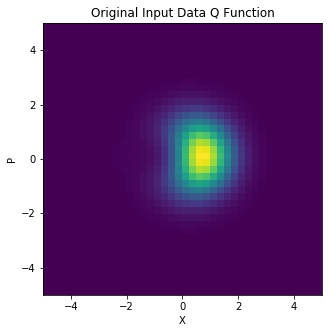

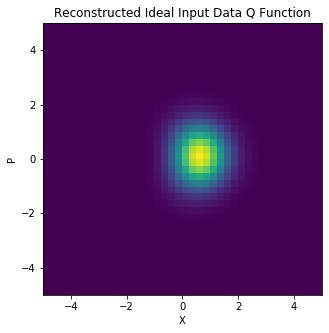

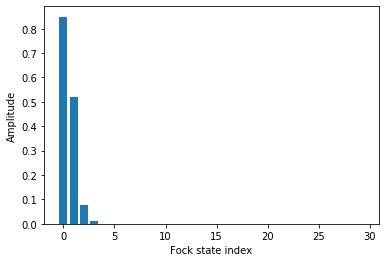

In [144]:
cst2.plot_coherent_state_tomography_Q_functions(actual_noisy_qfunc,
                                               reconstructed_state,
                                               xs,
                                               ps)

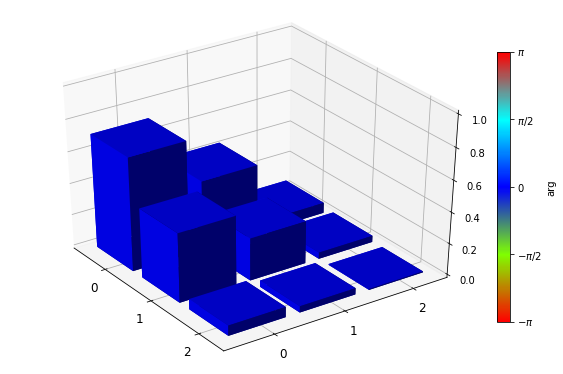

In [145]:
# Check first 3x3 block of the reconstructed density matrix
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(reconstructed_state,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)

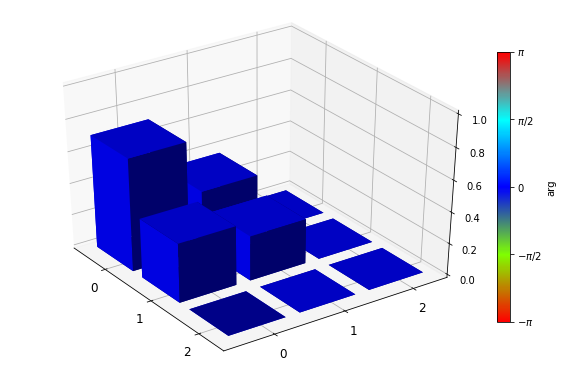

In [104]:
# Compare above to a photon-loss afflicted density matrix
efficiency = 1/(1 + 1 - actual_number_of_noise_photons)
photon_loss_state = cst2.bernoulli_transform(rho_target, efficiency, dim)

lower_cutoff = 0
upper_cutoff = 2
windowed_photon_loss_state = state_vis.windowed_density_matrix(photon_loss_state,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_photon_loss_state)

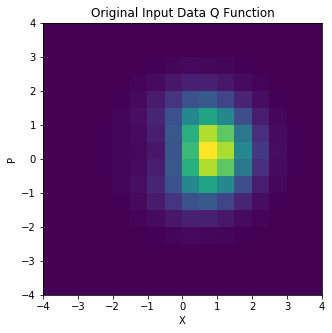

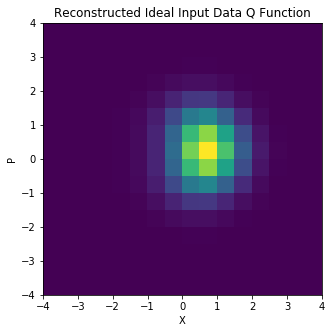

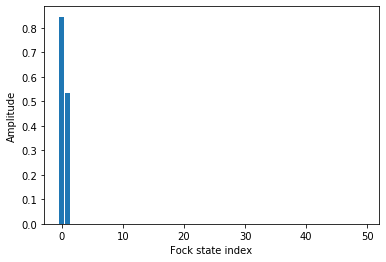

In [105]:
cst2.plot_coherent_state_tomography_Q_functions(actual_noisy_qfunc,
                                               qutip.Qobj(photon_loss_state),
                                               xs,
                                               ps)

In [124]:
print(qutip.fidelity(qutip.Qobj(rho_target), reconstructed_state))

0.9978797519873204


2